In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
UA = gpd.read_file("Data/Current_UA/Current_UA.shp")
glasgow_simd = gpd.read_file("Data/Glasgow_simd/Glasgow_simd.shp")
simd_pop = pd.read_csv("Data/simd2020_withinds.csv")
vacant_land = gpd.read_file("Data/VDL_centroids/VDL_centroids.shp")
vacant_land_poly = gpd.read_file("Data/VDL/Vacant_Derelict_Land.shp")

In [3]:
e_food_table = pd.read_csv("Data/efdi_scotland.csv")

In [4]:
glasgow_simd = glasgow_simd.merge(e_food_table,left_on="DataZone",right_on="LSOA or DZ")

In [5]:
cost_matrix_dz_ua = np.load("Data/cost_matrix_dz_ua.npy")
cost_matrix_dz_vdl = np.load("Data/cost_matrix_dz_vdl.npy")

### Define poor access as > 10min walking

In [6]:
poor_acc_dz = glasgow_simd.iloc[cost_matrix_dz_ua.min(axis=1)>600,:]
good_acc_dz = glasgow_simd.iloc[cost_matrix_dz_ua.min(axis=1)<=600,:]

poor_acc_dz.reset_index(inplace=True)

cost_matrix_poor_dz_vdl = cost_matrix_dz_vdl[cost_matrix_dz_ua.min(axis=1)>600,:]

In [8]:
exs_cover = 1 - poor_acc_dz['Total_popu'].sum()/glasgow_simd['Total_popu'].sum()
print(exs_cover)

0.35998840617049366


### Spatial optimisation MCLP

In [9]:
from spopt.locate.coverage import MCLP
import pulp

In [10]:
pulp.listSolvers(onlyAvailable=True)

['PULP_CBC_CMD', 'PULP_CHOCO_CMD']

In [11]:
def calculate_new_coverage(model):
    flat_list = [item for sublist in model.fac2cli for item in sublist]
    ind = np.unique(np.array(flat_list))
    return exs_cover + poor_acc_dz.iloc[ind,:]['Total_popu'].sum()/glasgow_simd['Total_popu'].sum()

In [12]:
from routingpy import OSRM
import json
import numpy as np
from scipy.stats import spearmanr

client = OSRM(base_url="http://localhost:4000")

In [13]:
vdl = np.array(list(zip(vacant_land.to_crs(epsg=4326).geometry.x,
                  vacant_land.to_crs(epsg=4326).geometry.y))).tolist()
dz = np.array(list(zip(glasgow_simd.centroid.to_crs(epsg=4326).geometry.x,
                  glasgow_simd.centroid.to_crs(epsg=4326).geometry.y))).tolist()
ua = np.array(list(zip(UA.to_crs(epsg=4326).geometry.x,
                  UA.to_crs(epsg=4326).geometry.y))).tolist()

In [14]:
def calculate_new_correlation(model):
    flat_list = [item for sublist in model.fac2cli for item in sublist]
    
    new_ua = []
    for j in range(len(model.fac2cli)):
        
        if len(model.fac2cli[j]) > 0:
            new_ua.append(j)
    
    new_ua = (ua + np.array(vdl)[new_ua].tolist())

    osrm_routing_matrix_ua = client.matrix(
        profile="walking",
        dry_run=False,
        locations=new_ua + dz,
        sources=list(range(0, len(new_ua))),
        destinations=list(range(len(new_ua), len(dz) + len(new_ua))),
    )
    cost_matrix_dz_ua = np.array(osrm_routing_matrix_ua.durations).T
    min_walk = cost_matrix_dz_ua.min(axis=1)
        
    return spearmanr(min_walk, glasgow_simd.Score.values)

In [ ]:
%%time
# With MCLP.from_cost_matrix we model the MCL problem to cover:
# all demand points with  facility points within a max_coverage 
# meters as service radius using cost matrix calculated previously.

cov_list = []
corr_list = []

#p_list = np.arange(5,cost_matrix_dz_vdl.shape[1]/3,10)
p_list = np.arange(0,201,5)

for p in p_list:
    solver = pulp.PULP_CBC_CMD(msg=True)   # see solvers available in pulp reference
    SERVICE_RADIUS = 600                    # max service duration, 10 mins (600 secs)
    ai = poor_acc_dz['Total_popu'].values  # weights

    # p_facilities = number of facilities to find eg x number of vacant land 

    mclp_from_cost_matrix = MCLP.from_cost_matrix(
    cost_matrix_poor_dz_vdl, ai, SERVICE_RADIUS, p_facilities=p
    )
    result = mclp_from_cost_matrix.solve(solver)
    mclp_from_cost_matrix.facility_client_array()
    
    cov = calculate_new_coverage(mclp_from_cost_matrix)
    
    corr = calculate_new_correlation(mclp_from_cost_matrix)
    print(p, cov, corr)
    
    cov_list.append(cov)
    corr_list.append(corr)

0 0.35998840617049366 SpearmanrResult(correlation=0.13192859247879785, pvalue=0.0003025260329807688)
5 0.40976136034266203 SpearmanrResult(correlation=0.10629283770307861, pvalue=0.00365443383227554)
10 0.45248784258155933 SpearmanrResult(correlation=0.09105260508948605, pvalue=0.012849291412054265)
15 0.4909342694277157 SpearmanrResult(correlation=0.0739773804573407, pvalue=0.04339123910985906)
20 0.5250716563073653 SpearmanrResult(correlation=0.014843232338274608, pvalue=0.6856571130164381)
25 0.5566084828185888 SpearmanrResult(correlation=0.0017020276745662224, pvalue=0.962983815545599)
30 0.5861179994203085 SpearmanrResult(correlation=0.006740459787819924, pvalue=0.8541738475732354)
35 0.6119239315964058 SpearmanrResult(correlation=-0.0028159208534358163, pvalue=0.9387966299767774)
40 0.6355093233712279 SpearmanrResult(correlation=-0.008267947654883579, pvalue=0.8216310606996139)
45 0.6566455186628449 SpearmanrResult(correlation=-0.03190841293340822, pvalue=0.38415031891101503)
50 

In [ ]:
plt.rcParams.update({'font.size': 14})

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6))
plt.plot(p_list,cov_list,lw=2)
plt.ylim(0.2,1)

plt.xlabel("Number of new urban agriculture projects")

plt.ylabel("Population coverage (%)")

plt.title("(a)")
plt.xticks(np.arange(0, 211, 15))

plt.savefig("mclp_cov.png",dpi=300)

In [ ]:
figure(figsize=(8, 6))
plt.plot(p_list,np.array(corr_list)[:,0],lw=2)
plt.xlabel("Number of new urban agriculture projects")
plt.ylabel("Spearman R")

plt.axvspan(15, 60, alpha=0.5, color='lightgreen')

plt.title("(b)")
plt.ylim(-0.20,0.20)
plt.xticks(np.arange(0, 211, 15))
plt.savefig("mclp_corr.png",dpi=300)

### Visualising distribution

In [27]:
def plot_new_ua(p):

    solver = pulp.PULP_CBC_CMD(msg=True)   # see solvers available in pulp reference
    SERVICE_RADIUS = 600                    # max service duration, 10 mins (600 secs)
    ai = poor_acc_dz['Total_popu'].values  # weights, decile

    # p_facilities = number of facilities to find eg x number of vacant land 

    mclp_from_cost_matrix = MCLP.from_cost_matrix(
    cost_matrix_poor_dz_vdl, ai, SERVICE_RADIUS, p_facilities=p
    )
    result = mclp_from_cost_matrix.solve(solver)
    mclp_from_cost_matrix.facility_client_array()


    new_ua = []
    for i in range(len(mclp_from_cost_matrix.fac2cli)):
        if len(mclp_from_cost_matrix.fac2cli[i])> 0:
            new_ua.append(i)
               
    flat_list = [item for sublist in mclp_from_cost_matrix.fac2cli for item in sublist]
    ind = np.unique(np.array(flat_list))
    
    new_dz = poor_acc_dz.iloc[ind,:]['index'].values
    
    
    ax=glasgow_simd.plot(figsize=(8,8),color="lightgrey",linewidth=0.2, edgecolor='white')
    vacant_land_poly.plot(ax=ax,color='black',legend=True,alpha=0)
    good_acc_dz.plot(ax=ax,color='lightgreen')

    glasgow_simd.iloc[new_dz,:].plot(ax=ax,color="lightcoral")
    vacant_land.iloc[new_ua,:].plot(ax=ax,color="red")

    plt.xticks([])
    plt.yticks([])
    plt.box()

    plt.title("New " + "(" + str(p) + ")" + " Urban Agriculture Projects",fontsize=14)
    plt.tight_layout()
    plt.savefig("New_UA_"+str(p)+".png",dpi=300)

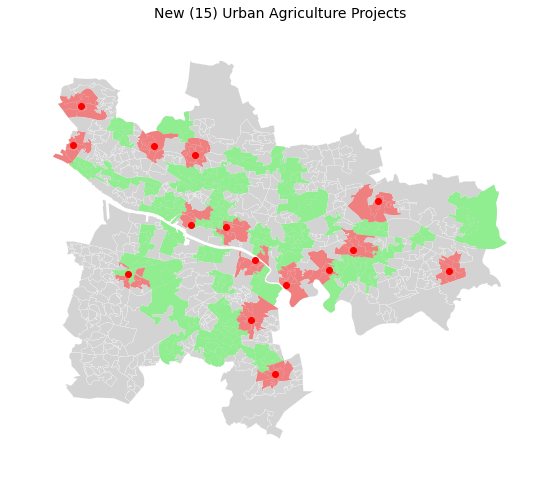

In [20]:
plot_new_ua(15)

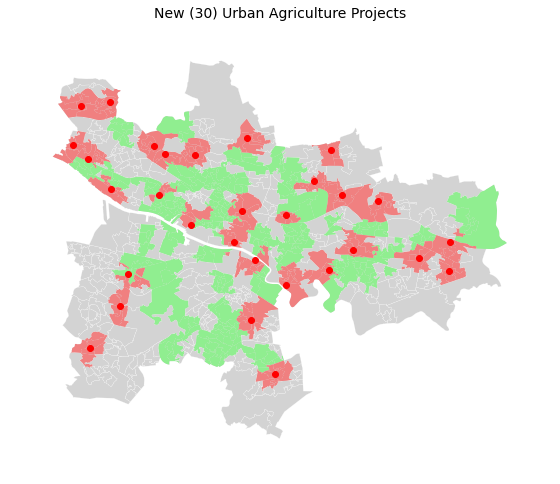

In [21]:
plot_new_ua(30)

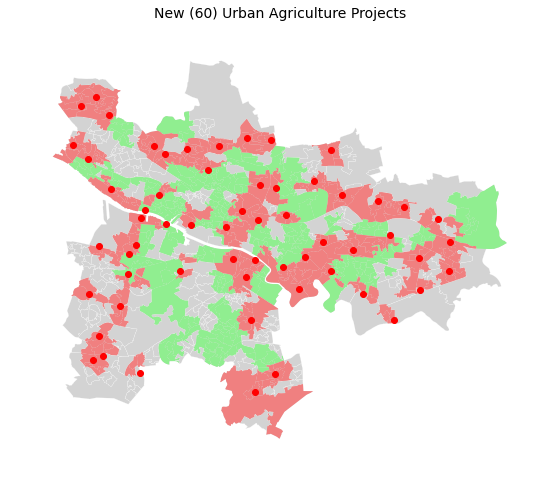

In [22]:
plot_new_ua(60)